# Imports

In [2]:
!pip install vit-pytorch
!pip install torchviz
!pip install torchsummary
!pip install timm
!pip install einops

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import gc
import time
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from collections import defaultdict, Counter

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as pt_optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as pt_lr_scheduler
from torchvision.datasets.folder import DatasetFolder

# Setup Dataset

In [3]:
import os

try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "ML4SCI_GSOC23")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  data_filepath = "data"
     


In [4]:
!cp /content/drive/MyDrive/datasets/ML4SCI_GSOC23/gravitational-lensing/Task1/dataset.zip .
!unzip -q dataset.zip

# EDA

In [33]:
import os

def getFilenamesFullPath(path):
  no_path = os.path.join(*path)
  no = os.listdir(no_path)
  return sorted([os.path.join(no_path, v) for v in no])

dataset_filepath_train = os.path.join("dataset", "train")
dataset_filepath_val = os.path.join("dataset", "val")

print(os.listdir(dataset_filepath_train))

no = getFilenamesFullPath(["dataset", "train", "no"])
vort = getFilenamesFullPath(["dataset", "train", "vort"])
sphere = getFilenamesFullPath(["dataset", "train", "sphere"])

print(f"size of no class : {len(no)}")
print(f"size of vort class : {len(vort)}")
print(f"size of sphere class : {len(sphere)}")

['sphere', 'vort', '.DS_Store', 'no']
size of no class : 10000
size of vort class : 10000
size of sphere class : 10000


In [34]:
no_ex = np.load(no[0])
vort_ex = np.load(vort[0])
sphere_ex = np.load(sphere[0])

print(f"no shape : {no_ex.shape}")
print(f"vort shape : {vort_ex.shape}")
print(f"sphere shape : {sphere_ex.shape}")

no shape : (1, 150, 150)
vort shape : (1, 150, 150)
sphere shape : (1, 150, 150)


## Plot some of the images

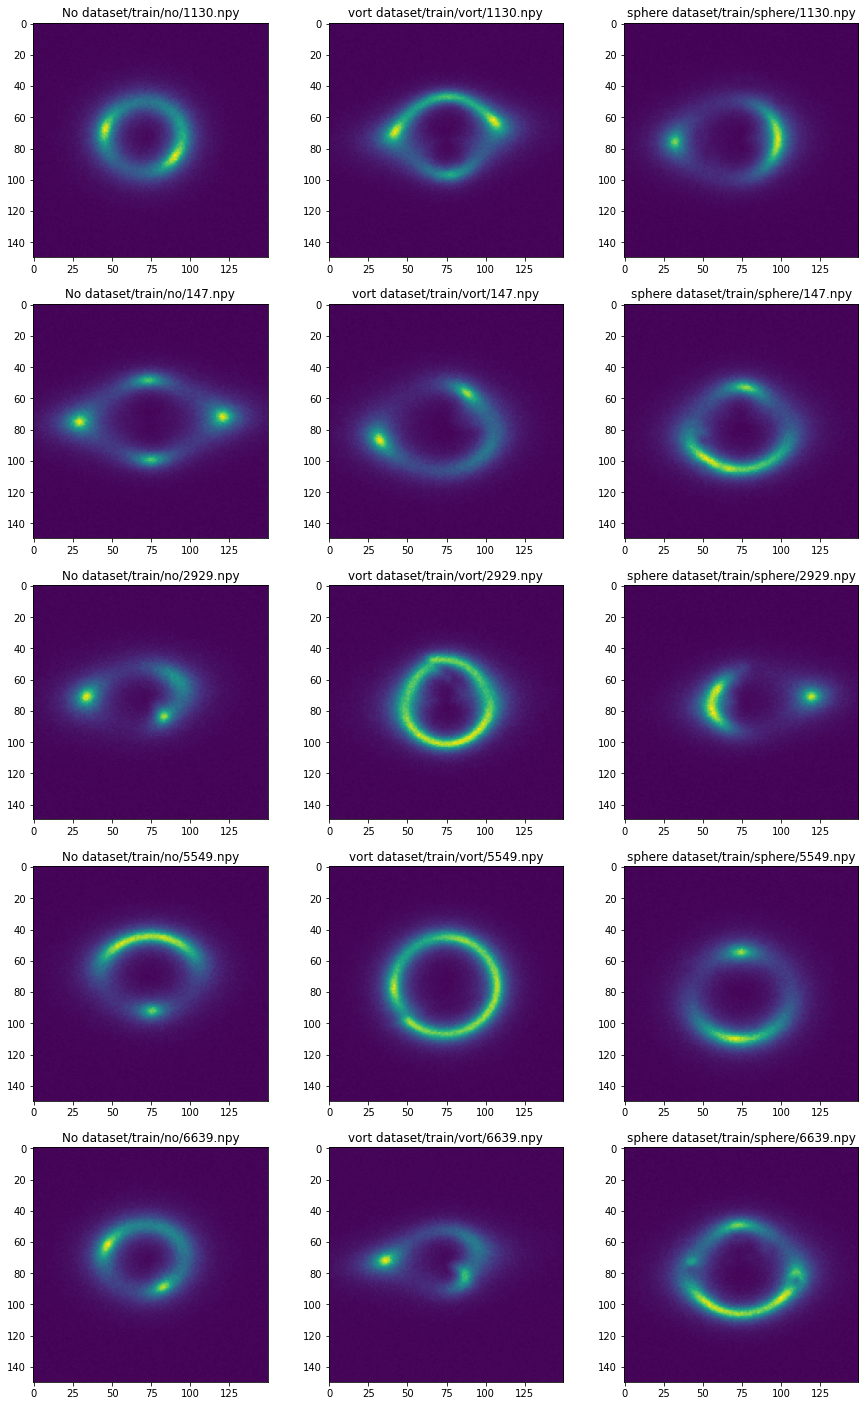

In [35]:
n = 5
size = 5

idxes = np.random.permutation(np.arange(0, len(no)))[:n]

plt.figure(figsize=(3 * size, n * size))
for i,idx in enumerate(idxes): 
  no_ex = np.load(no[idx]).transpose(1, 2, 0)
  vort_ex = np.load(vort[idx]).transpose(1, 2, 0)
  sphere_ex = np.load(sphere[idx]).transpose(1,2,0)

  plt.subplot(n, 3,  3 * i + 1)
  plt.title(f"No {no[idx]}")
  plt.imshow(no_ex)

  plt.subplot(n, 3,  3 * i + 2)
  plt.title(f"vort {vort[idx]}")
  plt.imshow(vort_ex)

  plt.subplot(n, 3,  3 * i + 3)
  plt.title(f"sphere {sphere[idx]}")
  plt.imshow(sphere_ex)

plt.show()

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

Device Used : cuda:0


In [4]:
def evaluate_model(model, valid_dataset, valid_dataset_len):
    since = time.time()

    # Each epoch has a training and validation phase
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    y = torch.Tensor()
    pred_y = torch.Tensor()
    criterion = nn.CrossEntropyLoss()

    # Iterate over data.
    for inputs, labels in tqdm(valid_dataset):
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        labels = labels.long()
        y = torch.cat([y, labels.cpu()])
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            probs, preds = torch.max(outputs, 1)
            
            #print(outputs.shape)
            loss = criterion(outputs, labels)

            pred_y = torch.cat([pred_y, outputs.cpu()])

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / valid_dataset_len
    epoch_acc = running_corrects.double() / valid_dataset_len
    AUC_ROC = roc_auc_score(y.detach().numpy(), F.softmax(pred_y, dim=1).detach().numpy(), multi_class="ovr")  

    
    time_elapsed = time.time() - since
    print(f'VALIDATION : Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since, 2)}')

In [5]:
def training_epoch(model, optimizer, scheduler, 
                   train_dataloader, train_dataset_size,
                   valid_dataloader, valid_dataset_size, 
                   num_epochs=25, update_every=5,
                   clean_every = 10):
    since = time.time()

    returnDict = {"trainingLoss" : [], "trainingAccuracy" : [], "epochs" : [], "trainingAUC" : []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        since2 = time.time()
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0
        y = torch.Tensor()
        pred_y = torch.Tensor()
        criterion = nn.CrossEntropyLoss()

        i = 0
        samples_so_far = 0
        # Iterate over data.
        progress_bar = tqdm(train_dataloader)
        for inputs, labels in progress_bar:
            i += 1
            samples_so_far += inputs.shape[0]
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            labels = labels.long()

            y = torch.cat([y, labels.cpu()])
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                probs, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                pred_y = torch.cat([pred_y, outputs.cpu()])

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i % update_every == 0:
                rl_avg = running_loss / samples_so_far
                acc_avg = running_corrects / samples_so_far
                AUC_ROC = roc_auc_score(y.detach().numpy(), F.softmax(pred_y, dim=1).detach().numpy(), multi_class="ovr")  

                progress_bar.set_description(f"loss = {rl_avg}, accuracy : {acc_avg}, AUC ROC {AUC_ROC}")
            
            if clean_every != -1 and i % clean_every == 0:
                gc.collect()

        scheduler.step()
        epoch_loss = running_loss / train_dataset_size
        epoch_acc = running_corrects.double() / train_dataset_size
        AUC_ROC = roc_auc_score(y.detach().numpy(), F.softmax(pred_y, dim=1).detach().numpy(), multi_class="ovr")  

        returnDict["trainingLoss"].append(epoch_loss)
        returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
        returnDict["trainingAUC"].append(AUC_ROC)

        print(f'TRAINING ; Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')
        evaluate_model(model, valid_dataloader, valid_dataset_size)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    returnDict["best_model"] = model
    return returnDict

In [6]:
def plotResults(results):
    plt.figure(figsize=(16,12))
    plt.subplot(3,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    plt.legend()

    plt.subplot(3,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    plt.legend()
  
  
    plt.subplot(3,1, 3)
    plt.plot(results['epochs'], results['trainingAUC'], label="training ROC")
    plt.legend()

    plt.show()

In [7]:
def doExperiment(model_ft, epochs=10, learning_rate=1e-3, plot=True, _summary=True, input_size=(3,32,32)):
  global train_dl, train_ds, val_dl, val_ds
  if _summary:
    print(summary(model_ft, input_size=input_size, device="cpu"))
  
  model_ft = model_ft.to(device)
  optim = pt_optim.Adam(model_ft.parameters(), lr=learning_rate)
  lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)

  dats = training_epoch(model_ft, optim, lr_sched, 
                        train_dl,  len(train_ds) , 
                        val_dl, len(val_ds),
                        num_epochs=epochs)
  
  if plot:
    plotResults(dats)
  return dats

In [16]:
batch_size = 32

train_ds = torchvision.datasets.CIFAR10("dataset/train_cifar", download=True, train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = torchvision.datasets.CIFAR10("dataset/val_cifar", download=True, train=False,
                                      transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ]))
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
print(f"size of training : {len(train_ds)}")
print(f"size of validation : {len(val_ds)}")

size of training : 50000
size of validation : 10000


torch.Size([32, 3, 32, 32]) torch.Size([32])
torch.Size([32, 3, 32, 32]) torch.Size([32])


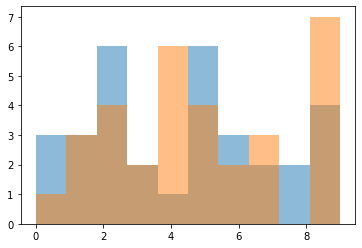

In [18]:
next_train = next(iter(train_dl)) 
print(next_train[0].shape, next_train[1].shape)

next_val = next(iter(val_dl)) 
print(next_val[0].shape, next_val[1].shape)

plt.hist(next_train[1].numpy(), alpha=0.5)
plt.hist(next_val[1].numpy(), alpha=0.5)
plt.show()

# Training

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 29, 29]           1,568
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 32, 11, 11]          16,416
         MaxPool2d-4             [-1, 32, 5, 5]               0
            Linear-5                  [-1, 256]         205,056
            Linear-6                   [-1, 10]           2,570
Total params: 225,610
Trainable params: 225,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 0.86
Estimated Total Size (MB): 1.16
----------------------------------------------------------------
None
Epoch 0/9
----------


loss = 1.3623294891837316, accuracy : 0.5082532167434692, AUC ROC 0.8895370262409777: 100%|██████████| 1563/1563 [00:42<00:00, 36.80it/s] 


TRAINING ; Loss: 1.3620 Acc: 0.5083 AUC ROC : 0.8896 Time taken : 42.58


100%|██████████| 313/313 [00:02<00:00, 149.51it/s]


VALIDATION : Loss: 1.1115 Acc: 0.6038 AUC ROC : 0.9285 Time taken : 2.12
Epoch 1/9
----------


loss = 1.0130938405409837, accuracy : 0.6463141441345215, AUC ROC 0.9380883629374909: 100%|██████████| 1563/1563 [00:43<00:00, 35.88it/s]


TRAINING ; Loss: 1.0130 Acc: 0.6464 AUC ROC : 0.9381 Time taken : 43.68


100%|██████████| 313/313 [00:02<00:00, 143.75it/s]


VALIDATION : Loss: 0.9763 Acc: 0.6590 AUC ROC : 0.9431 Time taken : 2.2
Epoch 2/9
----------


loss = 0.86080136476801, accuracy : 0.7029046416282654, AUC ROC 0.954571763223347: 100%|██████████| 1563/1563 [00:44<00:00, 34.76it/s]   


TRAINING ; Loss: 0.8607 Acc: 0.7029 AUC ROC : 0.9546 Time taken : 45.13


100%|██████████| 313/313 [00:02<00:00, 137.40it/s]


VALIDATION : Loss: 0.9912 Acc: 0.6702 AUC ROC : 0.9475 Time taken : 2.3
Epoch 3/9
----------


loss = 0.7514196714529624, accuracy : 0.7372395992279053, AUC ROC 0.9648199653532059: 100%|██████████| 1563/1563 [00:44<00:00, 35.41it/s]


TRAINING ; Loss: 0.7513 Acc: 0.7372 AUC ROC : 0.9648 Time taken : 44.25


100%|██████████| 313/313 [00:02<00:00, 147.32it/s]


VALIDATION : Loss: 0.8875 Acc: 0.6917 AUC ROC : 0.9549 Time taken : 2.15
Epoch 4/9
----------


loss = 0.6692951222642874, accuracy : 0.7656049728393555, AUC ROC 0.9718316641850622: 100%|██████████| 1563/1563 [00:42<00:00, 36.58it/s]


TRAINING ; Loss: 0.6694 Acc: 0.7656 AUC ROC : 0.9718 Time taken : 42.84


100%|██████████| 313/313 [00:02<00:00, 141.98it/s]


VALIDATION : Loss: 0.8678 Acc: 0.7087 AUC ROC : 0.9560 Time taken : 2.23
Epoch 5/9
----------


loss = 0.5943088320203317, accuracy : 0.7908053398132324, AUC ROC 0.9775283764487869: 100%|██████████| 1563/1563 [00:42<00:00, 36.83it/s]


TRAINING ; Loss: 0.5943 Acc: 0.7908 AUC ROC : 0.9775 Time taken : 42.66


100%|██████████| 313/313 [00:03<00:00, 94.97it/s] 


VALIDATION : Loss: 0.9185 Acc: 0.7052 AUC ROC : 0.9537 Time taken : 3.33
Epoch 6/9
----------


loss = 0.5215927463693496, accuracy : 0.817267656326294, AUC ROC 0.9824742703700269: 100%|██████████| 1563/1563 [00:43<00:00, 36.02it/s] 


TRAINING ; Loss: 0.5216 Acc: 0.8173 AUC ROC : 0.9825 Time taken : 43.5


100%|██████████| 313/313 [00:02<00:00, 149.76it/s]


VALIDATION : Loss: 0.9404 Acc: 0.7069 AUC ROC : 0.9542 Time taken : 2.11
Epoch 7/9
----------


loss = 0.4652888034016658, accuracy : 0.8345953822135925, AUC ROC 0.9858488267077543: 100%|██████████| 1563/1563 [00:42<00:00, 36.80it/s] 


TRAINING ; Loss: 0.4651 Acc: 0.8347 AUC ROC : 0.9859 Time taken : 42.59


100%|██████████| 313/313 [00:02<00:00, 143.59it/s]


VALIDATION : Loss: 0.9878 Acc: 0.7043 AUC ROC : 0.9537 Time taken : 2.2
Epoch 8/9
----------


loss = 0.40584319514246325, accuracy : 0.8560497164726257, AUC ROC 0.9890720768620695: 100%|██████████| 1563/1563 [00:42<00:00, 37.18it/s]


TRAINING ; Loss: 0.4057 Acc: 0.8561 AUC ROC : 0.9891 Time taken : 42.14


100%|██████████| 313/313 [00:01<00:00, 158.55it/s]


VALIDATION : Loss: 1.0664 Acc: 0.7026 AUC ROC : 0.9521 Time taken : 2.0
Epoch 9/9
----------


loss = 0.36045060367204057, accuracy : 0.8727564215660095, AUC ROC 0.9913294948887567: 100%|██████████| 1563/1563 [00:40<00:00, 38.22it/s]


TRAINING ; Loss: 0.3605 Acc: 0.8727 AUC ROC : 0.9913 Time taken : 41.06


100%|██████████| 313/313 [00:02<00:00, 149.52it/s]


VALIDATION : Loss: 1.1540 Acc: 0.6990 AUC ROC : 0.9507 Time taken : 2.12
Training complete in 7m 33s


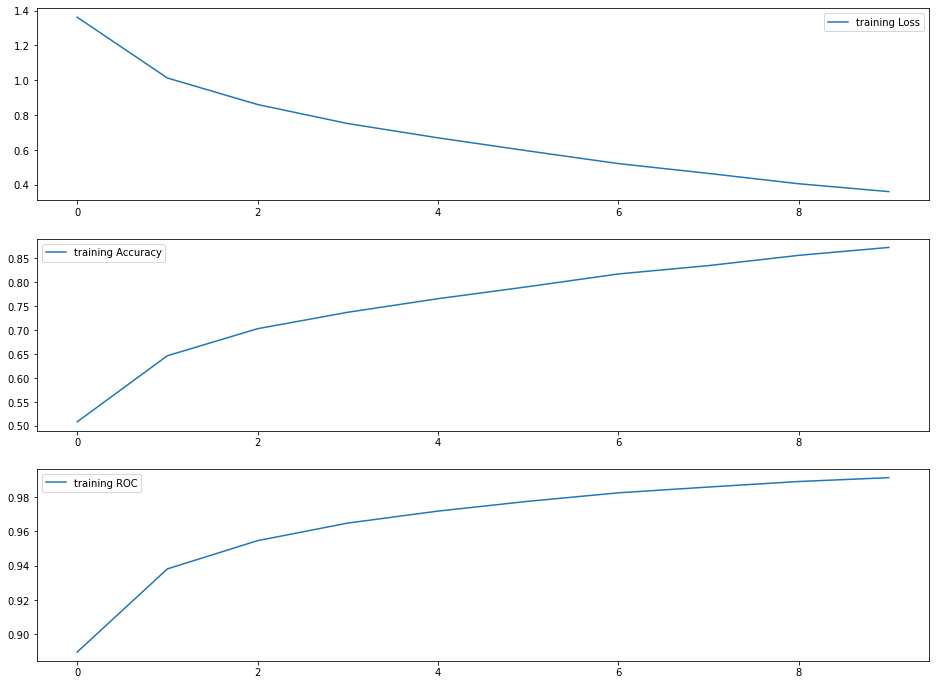

{'trainingLoss': [1.3620203083610534,
  1.0129834103393556,
  0.8606791193580627,
  0.7513446152877807,
  0.6694370420455933,
  0.5943144024276733,
  0.5215514915180206,
  0.4650817749786377,
  0.40566733882427214,
  0.36050030524492266],
 'trainingAccuracy': [0.50834,
  0.6464200000000001,
  0.7029000000000001,
  0.73724,
  0.76558,
  0.79076,
  0.8172600000000001,
  0.83472,
  0.8561400000000001,
  0.8727],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'trainingAUC': [0.889584672888889,
  0.9380961651111113,
  0.9545813177777778,
  0.9648276637777778,
  0.9718188986666666,
  0.9775308453333335,
  0.9824744288888889,
  0.9858616868888888,
  0.9890813782222221,
  0.9913296848888888],
 'best_model': Net(
   (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
   (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
   (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [20]:
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(800, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return self.fc2(x)


doExperiment(Net(), 
             input_size=(3,32,32), learning_rate=1e-3)